In [1]:
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
sys.path.append('../')

from sph_modules import (compute_hsm,
                         compute_hsm_tensor,
                         
                         compute_density,
                         compute_div,
                         compute_rot,
                         
                         quintic_spline_gradient)

from pgpy import (cic_deposition, 
                  isotropic_kernel_deposition, 
                  anisotropic_kernel_deposition)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
ds = pn.load('../../../../../shares/feldmann.ics.mnf.uzh/data/FIREbox/production_runs/FB15N128/snapshot_554.hdf5')


boxsize  = 15000
NN       = 32
periodic = True
gridnum  = 512
extent   = np.array([0, boxsize])

pos      = ds.gas['pos']
masses   = ds.gas['mass']
vel      = ds.gas['vel']
vx       = ds.gas['vel'][:, 0]
vy       = ds.gas['vel'][:, 1]
vz       = ds.gas['vel'][:, 2]


# IMPORTANT: hsm (tensor) needs to be computed from the 3d distribution (unless the simulation is 2d)!!
hsm, nn_dists, nn_inds, _ = compute_hsm(pos, NN, boxsize)


# compute particle density
ρ = compute_density(dim=3, 
                    hsm=hsm,
                    masses=masses,
                    nn_dists=nn_dists, 
                    nn_inds=nn_inds)

/home/maurbe/data/conda/envs/wenv/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:555: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)
/home/maurbe/data/conda/envs/wenv/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:394: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


In [3]:
# compute kernel gradients
grad_w = quintic_spline_gradient(dim=3,
                                 pos=pos,
                                 h=hsm,
                                 nn_inds=nn_inds)

div_rho = compute_div(masses, ρ, ρ, nn_inds, grad_w)
rot_vel = compute_rot(masses, ρ, vel, nn_inds, grad_w)

In [4]:
# stack all quantities to deposit
quantities = np.stack([masses,
                       vx, vy, vz,
                       div_rho[:, 0], div_rho[:, 1], div_rho[:, 2],
                       rot_vel[:, 0], rot_vel[:, 1], rot_vel[:, 2],
                      ], axis=-1); print(quantities.shape)

# do we need to average the deposited quantities or not?
averaged   = [False,
              True, True, True,
              True, True, True,
              True, True, True]

(1949593, 10)


In [5]:
mask = np.logical_and(pos[:, -1] > 14000,
                      pos[:, -1] < 15000)

pos    = pos[mask]
masses = masses[mask]
hsm    = hsm[mask]
quantities = quantities[mask]

pos = pos[:, :2]

kwargs = {'positions': pos, 
          'quantities': quantities, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1}

In [6]:
fields_cic, _ = cic_deposition(**kwargs)

fields_ada, _ = cic_deposition(**kwargs, num_nn=NN)

fields_iso, _ = isotropic_kernel_deposition(**kwargs, hsm=hsm)

100%|██████████| 153687/153687 [00:28<00:00, 5349.87it/s] 


In [7]:
fields = [fields_cic,
          fields_ada, 
          fields_iso
          ]

In [20]:
def trsf_1(v):
    return np.sign(v) * np.log10(np.abs(v))

/sctmp/maurbe/ipykernel_2612970/1695711008.py:6: RuntimeWarning: divide by zero encountered in log10
  ax[j, 0].imshow(np.log10(fields[j][fov][...,0]), cmap='bone', vmin=-5)
/sctmp/maurbe/ipykernel_2612970/1004292481.py:2: RuntimeWarning: divide by zero encountered in log10
  return np.sign(v) * np.log10(np.abs(v))
/sctmp/maurbe/ipykernel_2612970/1004292481.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sign(v) * np.log10(np.abs(v))


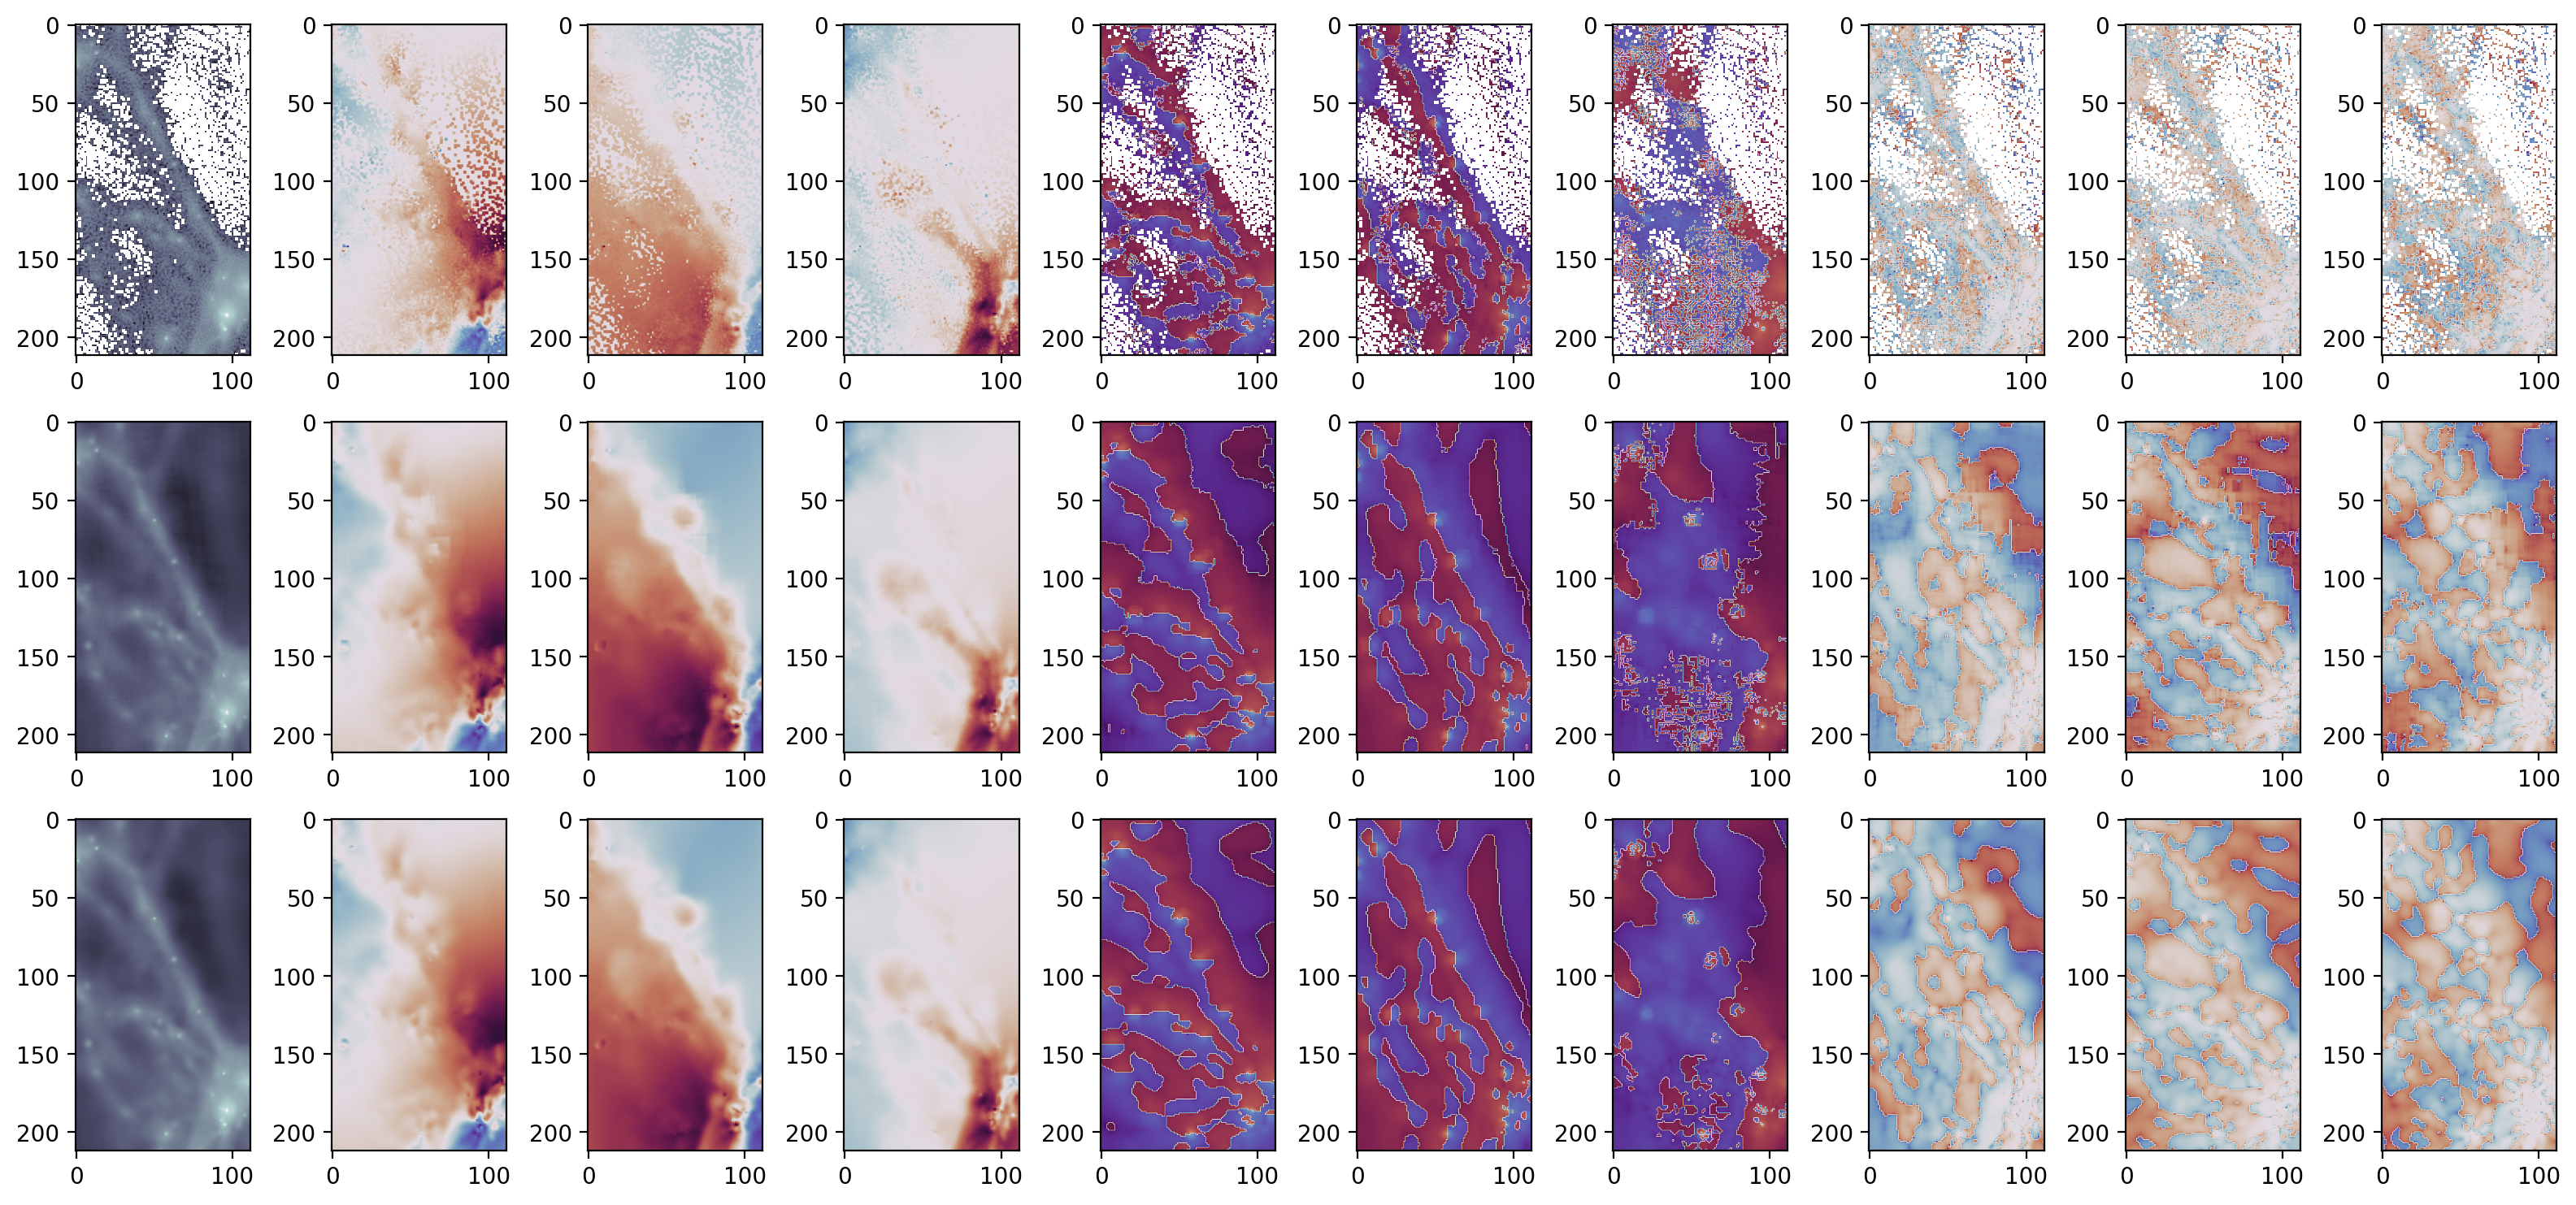

In [21]:
fig, ax = plt.subplots(3, 10, figsize=(20, 9))

for j in range(3):
    fov = np.s_[300:, 400:]

    ax[j, 0].imshow(np.log10(fields[j][fov][...,0]), cmap='bone', vmin=-5)
    
    ax[j, 1].imshow(fields[j][fov][...,1], cmap='twilight_shifted', norm=colors.CenteredNorm())
    ax[j, 2].imshow(fields[j][fov][...,2], cmap='twilight_shifted', norm=colors.CenteredNorm())
    ax[j, 3].imshow(fields[j][fov][...,3], cmap='twilight_shifted', norm=colors.CenteredNorm())
    
    ax[j, 4].imshow(trsf_1(fields[j][fov][...,4]), cmap='twilight_shifted', norm=colors.CenteredNorm())
    ax[j, 5].imshow(trsf_1(fields[j][fov][...,5]), cmap='twilight_shifted', norm=colors.CenteredNorm())
    ax[j, 6].imshow(trsf_1(fields[j][fov][...,6]), cmap='twilight_shifted', norm=colors.CenteredNorm())
    
    ax[j, 7].imshow(trsf_1(fields[j][fov][...,7]), cmap='twilight_shifted', norm=colors.CenteredNorm())
    ax[j, 8].imshow(trsf_1(fields[j][fov][...,8]), cmap='twilight_shifted', norm=colors.CenteredNorm())
    ax[j, 9].imshow(trsf_1(fields[j][fov][...,9]), cmap='twilight_shifted', norm=colors.CenteredNorm())

fig.savefig('plots/deposition_comparison_grad_W.png', transparent=True, dpi=300)
plt.show()